# Automation of Bulk Preprocessing of Sentinel Images using Graph Processing Tool (GPT)

This Jupyter Notebook automates the preprocessing of Sentinel-2 images through Graph Processing Tool (GPT) using the XML file saved from the Sentinel Application Platform's (SNAP's) Graph Builder tool. This allows to take advantage of the batch proessing option available in SNAP GPT. Here, the specific processing chain was defined (**Figure 1**) and the defined chain was applied can be applied to several images in an automatic way (In this Notebook, two Sentinel-2 images are used. However, this approach can be applied to several Sentinel-2 and/or Sentinel-1 images). This method allows reducing processing time and storage requirement since no intermediate steps outputs are created and stored. Only the final product is physically saved. The Notebook uses the resources from Mac's Terminal and Python library. This Notebook is prepared based on the NASA ARSET's training "[Agricultural Crop Classification with Synthetic Aperture Radar and Optical Remote Sensing](https://appliedsciences.nasa.gov/join-mission/training/english/arset-agricultural-crop-classification-synthetic-aperture-radar-and)".

**Remember:** To run this Notebook, first the SNAP software should be downloaded and installed (http://step.esa.int/main/download/snap-download/).

![GraphBuilder](./images/Graph_Builder_from_SNAP_1.png "Title")
<center>Figure 1: Screenshot of Graph Builder Window from SNAP Software. </center>

## Sentinel-2 Data Download

To use this script, first the two Sentinel-2 Level 2A (given below) data products should be downloaded from the [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and saved in the "data" folder. 
> - S2A_MSIL2A_20200627T101031_N0214_R022_T32TQQ_20200627T120035
> - S2A_MSIL2A_20200707T101031_N0214_R022_T32TQQ_20200707T135316

## Editing Graph Builder XML File

In [1]:
!cat ./data/S2_Graph.xml

<graph id="Graph">
  <version>1.0</version>
  <node id="Read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <file>/xxxxx/xxxxx/S2A_MSIL2A_20200627T101031_N0214_R022_T32TQQ_20200627T120035.SAFE/MTD_MSIL2A.xml</file>
    </parameters>
  </node>
  <node id="Resample">
    <operator>Resample</operator>
    <sources>
      <sourceProduct refid="Read"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <referenceBand/>
      <targetWidth/>
      <targetHeight/>
      <targetResolution>10</targetResolution>
      <upsampling>Nearest</upsampling>
      <downsampling>First</downsampling>
      <flagDownsampling>First</flagDownsampling>
      <resamplingPreset/>
      <bandResamplings/>
      <resampleOnPyramidLevels>true</resampleOnPyramidLevels>
    </parameters>
  </node>
  <node id="Reproject">
    <operator>Reproject</operator>
    <sources>
      <sourceProduct refid="Resample"/>
    </

The limitation of the above Graph Builder XML file is that you can only process one file. In order to make the XML dynamic for multiple input and output files, we need to make some changes to the XML file. This editing can be done either manually or through Python xml.etree.ElementTree library. The modification of the XML file can be done as follows:

- Search for the *Read* node. Within that node, a line should list the Sentinel 2 file you used when creating the Graph Builder in SNAP software. 
- Replace the filename (/xxxxx/xxxxx/S2A_MSIL2A_20200627T101031_N0214_R022_T32TQQ_20200627T120035.SAFE/MTD_MSIL2A.xml) with the placeholder \$input (this change makes the XML file to accept any Sentinel image). 
- Similarly, now search for the **Write** node and replace the filename (/xxxxx/xxxxx/S2A_MSIL2A_20200627T101031_N0214_R022_T32TQQ_20200627T120035_resam_repro_subset.dim) with the placeholder \$output.

In [2]:
from xml.etree import ElementTree as et

with open('./data/S2_Graph.xml', encoding='latin-1') as f:
    tree = et.parse(f)
    root = tree.getroot()
    
    for elem in root.getiterator():
        try:
            elem.text = elem.text.replace('/xxxxx/xxxxx/S2A_MSIL2A_20200627T101031_N0214_R022_T32TQQ_20200627T120035.SAFE/MTD_MSIL2A.xml', '$input')
            elem.text = elem.text.replace('/xxxxx/xxxxx/S2A_MSIL2A_20200627T101031_N0214_R022_T32TQQ_20200627T120035_resam_repro_subset.dim', '$output')
        except AttributeError:
            pass
        
tree.write('./data/S2_Graph_Final.xml', encoding='latin-1')

## Preparing Bash Script (.sh) for Batch Processing using GPT

A file with .sh extension is a scripting language commands file that contains computer program to be run by Unix shell ([Source](https://docs.fileformat.com/programming/sh/)).

Graph Processing Tool (GPT) is a SNAP command line interface (which can be found in the bin folder of the Sentinel Toolbox installation) to process the Sentinel images. This tool is used to execute SNAP raster data operators in bulk processing mode. The operators can be used stand-alone or combined as a directed acyclic graph (DAG).

In [9]:
!/Applications/snap/bin/gpt ## To access GPT and to see the options for GPT

In [4]:
%%writefile ./data/Script_GPT_Final.sh
#!/bin/bash


# 1- Define path variables 

Path_S2=./data/
Path_output=./output/ 

# 2- Define name variables

oldEnd=.SAFE
preprocPol=_resam_reproj_subset 

# 3- Extract filename & run GPT

for i in $(ls -d -1 $Path_S2$S2A*.SAFE) 
do
m=${i##*/}
n=${m%.*}
    date
    /Applications/snap/bin/gpt ./data/S2_Graph_Final.xml -Pinput=$i -Poutput="$Path_output$n$preprocPol"
    date
done

Overwriting ./data/Script_GPT_Final.sh


## Running the Bash Script

In [5]:
%%bash
chmod +x ./data/Script_GPT_Final.sh ## To make the file executable (to fix the problem "Permission denied" from Terminal)

In [6]:
!./data/Script_GPT_Final.sh

Sat Oct 30 00:14:41 MDT 2021
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.2.1 found on system. Internal GDAL 3.0.0 from distribution will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.
Executing processing graph
INFO: org.esa.s2tbx.dataio.s2.ortho.S2OrthoProductReaderPlugIn: Building product reader - EPSG:32632
INFO: org.hsqldb.persist.Logger: dataFileCache open start


.15%.30%.45%..56%.67%.82%. done.
Sat Oct 30 00:16:08 MDT 2021
Sat Oct 30 00:16:08 MDT 2021
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: In

## Visualizing RGB Images from the Processed Output

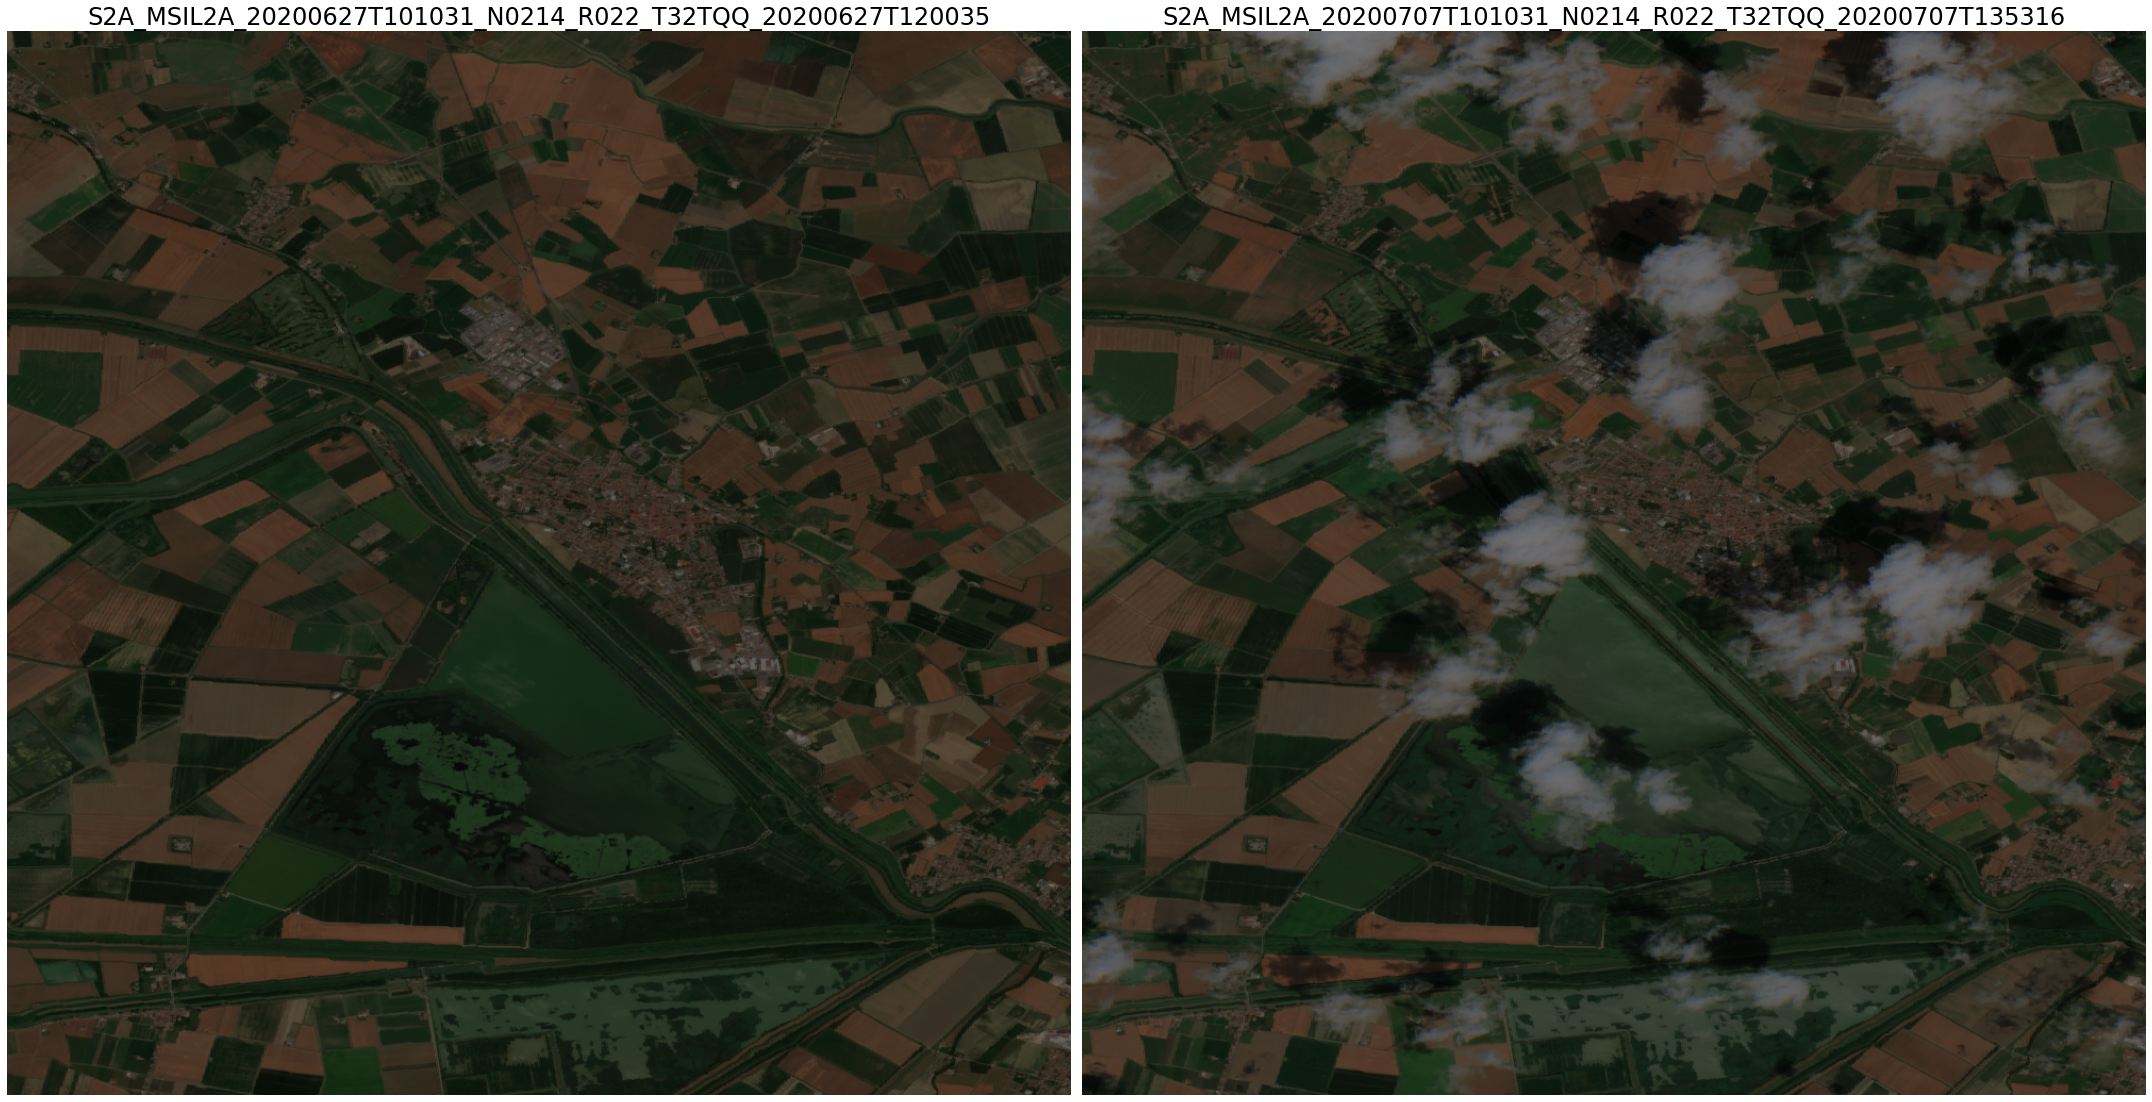

In [7]:
import snappy
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from glob import glob

imgage_filenames = sorted(glob("./output/*.dim"))

fig, axes = plt.subplots(1,2, figsize=(30,20))
axes = axes.ravel()

for i, ax in enumerate(axes):
    
    p = snappy.ProductIO.readProduct(imgage_filenames[i])
    title_name = imgage_filenames[i][(imgage_filenames[i].find('S2A_MSIL2A')):(imgage_filenames[i].find('_resam')-0)]
        
    band_2 = p.getBand('B2')
    band_3 = p.getBand('B3')
    band_4 = p.getBand('B4')
    w = band_2.getRasterWidth()
    h = band_2.getRasterHeight()

    band_2_data = np.zeros(w * h, np.float32)
    band_3_data = np.zeros(w * h, np.float32)
    band_4_data = np.zeros(w * h, np.float32)

    band_2.readPixels(0, 0, w, h, band_2_data)
    band_3.readPixels(0, 0, w, h, band_3_data)
    band_4.readPixels(0, 0, w, h, band_4_data)

    p.dispose()

    band_2_data.shape = h, w
    band_3_data.shape = h, w
    band_4_data.shape = h, w
    
    axes[i].axis("off")
    image = make_lupton_rgb(band_4_data, band_3_data, band_2_data, stretch=0.5)
    im = axes[i].imshow(image)
    ax.set_title(title_name,fontsize=24) 

plt.tight_layout()  
plt.savefig('./output/RGB_Images_from_the_Processed_Outputs.png',dpi=100,bbox_inches='tight')
plt.show()